# Импорт

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [32]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
!pip install livelossplot
from livelossplot.inputs.tf_keras import PlotLossesCallback

TensorFlow is already loaded. Please restart the runtime to change versions.


# Загрузка данных

In [17]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [18]:
! ls /root/.keras/datasets/cats_and_dogs_filtered

train  validation  vectorize.py


In [19]:
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'

In [20]:
num_cats_tr = len(list(train_cats_dir.glob("*")))
num_dogs_tr = len(list(train_dogs_dir.glob("*")))

num_cats_val = len(list(validation_cats_dir.glob("*")))
num_dogs_val = len(list(validation_dogs_dir.glob("*")))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [21]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Формируем модель

In [22]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 

In [23]:
train_image_generator = ImageDataGenerator(rescale=1./255)  
validation_image_generator = ImageDataGenerator(rescale=1./255)  

In [24]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                           class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
sample_training_images, sample_labels = next(train_data_gen) 

In [57]:
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

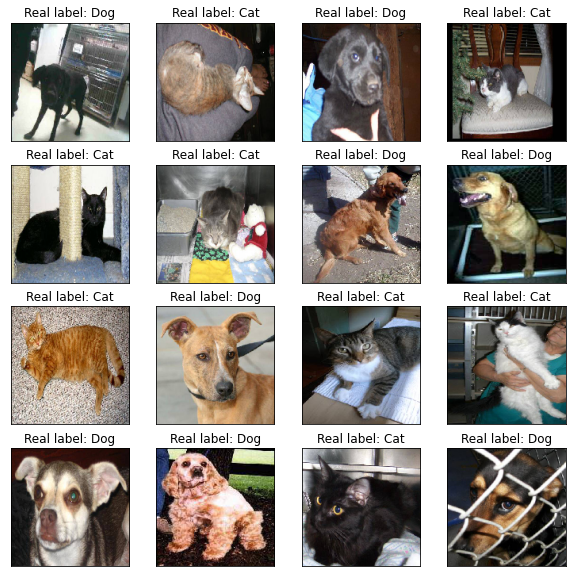

In [27]:
show_catsdogs(sample_training_images, sample_labels)

In [28]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu',
                                 input_shape=(IMG_SHAPE,IMG_SHAPE,3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 128)      

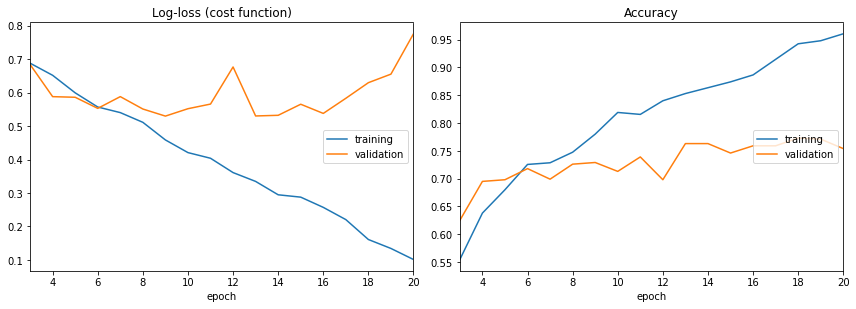

Log-loss (cost function):
training   (min:    0.101, max:    0.717, cur:    0.101)
validation (min:    0.530, max:    0.776, cur:    0.776)

Accuracy:
training   (min:    0.504, max:    0.961, cur:    0.961)
validation (min:    0.500, max:    0.773, cur:    0.754)
20/20 [==============================] - 7s 354ms/step - loss: 0.1012 - acc: 0.9605 - val_loss: 0.7758 - val_acc: 0.7540


In [30]:
EPOCHS = 20
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

Found 1000 images belonging to 2 classes.


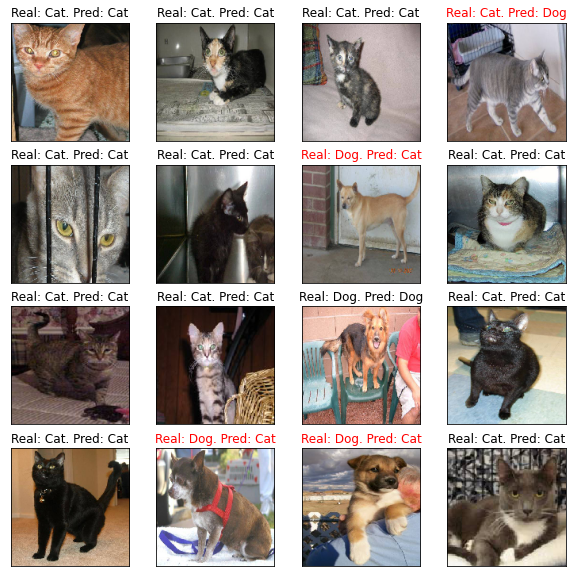

In [31]:
shuffle_val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='binary')
sample_validation_images, sample_validation_labels = next(shuffle_val_data_gen)
predicted = model.predict_classes(sample_validation_images).flatten()
show_catsdogs(sample_validation_images, sample_validation_labels, predicted)

### Как видно по кривым обучения, произошло переобучение. Добавим аугментацию данных и уменьшим колличество парметров модели

In [32]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.GlobalAveragePooling2D(), # добавим GAP
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

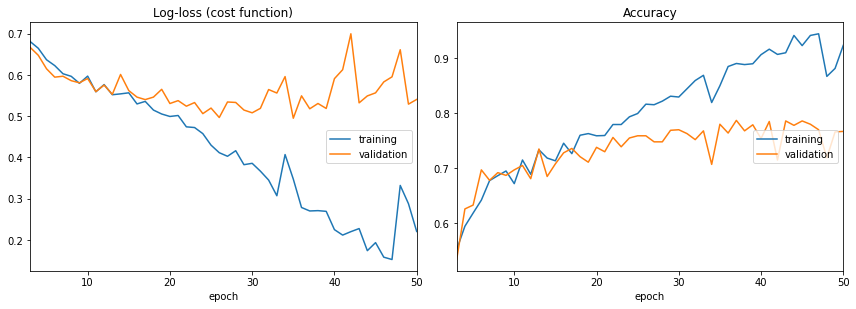

Log-loss (cost function):
training   (min:    0.153, max:    0.694, cur:    0.221)
validation (min:    0.495, max:    0.700, cur:    0.541)

Accuracy:
training   (min:    0.491, max:    0.945, cur:    0.924)
validation (min:    0.534, max:    0.787, cur:    0.767)
20/20 [==============================] - 7s 363ms/step - loss: 0.2207 - acc: 0.9235 - val_loss: 0.5407 - val_acc: 0.7670


In [33]:
EPOCHS = 50
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

### Уже лучше, добавим аугментацию

In [58]:
train_image_gen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,  # максимальный угол поворота
      width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
      height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
      zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20% 
      horizontal_flip=True, # случайное отражение по горизонтали
      fill_mode="nearest"
      ) 



train_data_gen = train_image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


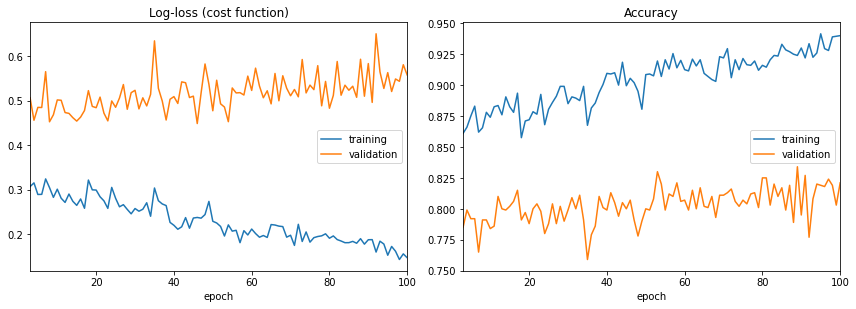

Log-loss (cost function):
training   (min:    0.143, max:    0.324, cur:    0.147)
validation (min:    0.449, max:    0.651, cur:    0.558)

Accuracy:
training   (min:    0.855, max:    0.942, cur:    0.940)
validation (min:    0.759, max:    0.834, cur:    0.821)
20/20 [==============================] - 15s 763ms/step - loss: 0.1467 - acc: 0.9400 - val_loss: 0.5579 - val_acc: 0.8210


In [59]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

# Попробуем Transfer learning

In [46]:
IMG_SHAPE  = 150 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
image_gen_train = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

validation_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)  
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [47]:
IMG_SHAPE = (150, 150, 3)
# базовая модель -- MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False # замораживаем всю базовую модель
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [48]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


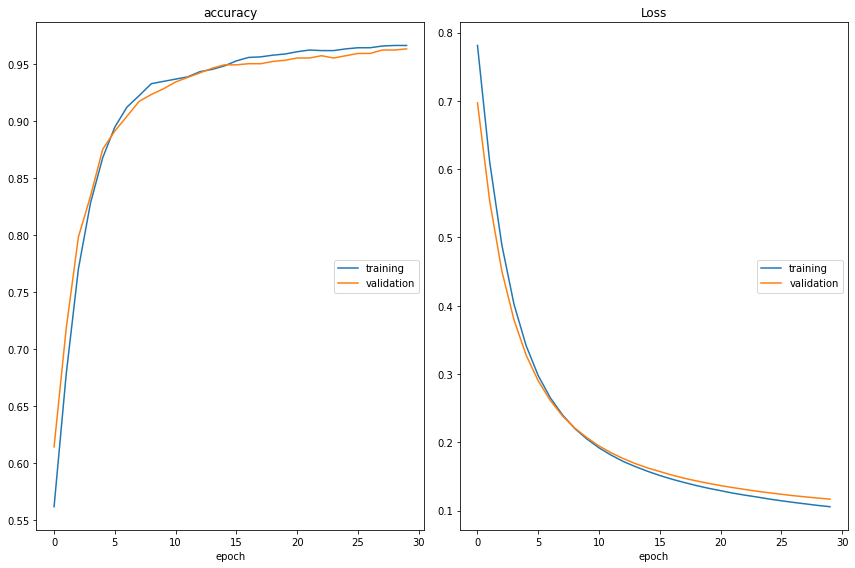

accuracy
	training         	 (min:    0.562, max:    0.966, cur:    0.966)
	validation       	 (min:    0.614, max:    0.963, cur:    0.963)
Loss
	training         	 (min:    0.106, max:    0.781, cur:    0.106)
	validation       	 (min:    0.117, max:    0.697, cur:    0.117)
20/20 [==============================] - 8s 409ms/step - loss: 0.1056 - accuracy: 0.9660 - val_loss: 0.1167 - val_accuracy: 0.9630


In [50]:
EPOCHS = 30
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

### Fine tunning

In [51]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  155


In [52]:
fine_tune_at = 100
# все слои до -- заморозим
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-5), # уменьшили скорость обучения
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


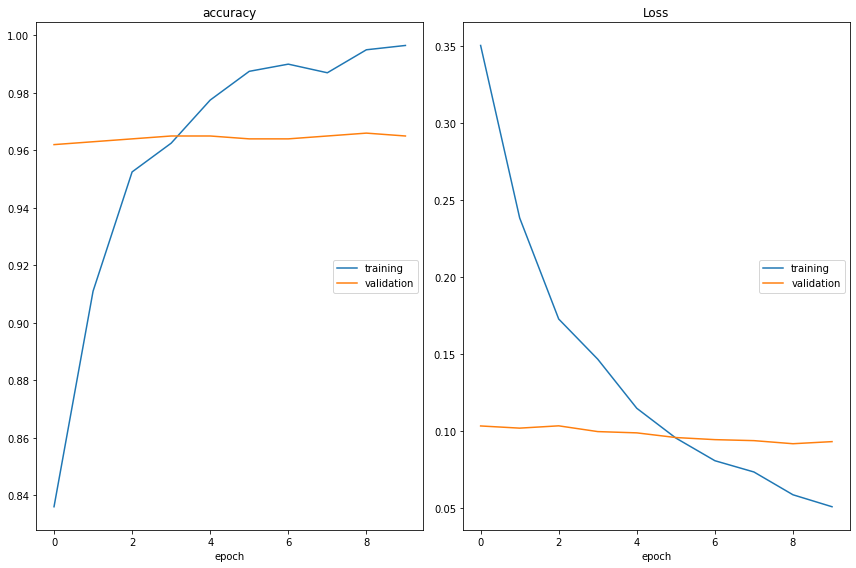

accuracy
	training         	 (min:    0.836, max:    0.997, cur:    0.997)
	validation       	 (min:    0.962, max:    0.966, cur:    0.965)
Loss
	training         	 (min:    0.051, max:    0.350, cur:    0.051)
	validation       	 (min:    0.092, max:    0.104, cur:    0.093)
20/20 [==============================] - 8s 406ms/step - loss: 0.0510 - accuracy: 0.9965 - val_loss: 0.0933 - val_accuracy: 0.9650


In [53]:
EPOCHS = 10
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])